In [1]:
# Imports and setup
import pickle
import numpy as np
from multiprocessing import Pool
import requests, json
import pandas as pd
import glob
import time
import re
import matplotlib as mpl
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.transforms as mtransforms
from scipy import stats
from pandas.plotting import register_matplotlib_converters

# Configure matplotlib
sns.set_theme(style='white')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.rcParams['xtick.major.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
sns.set_context('talk', font_scale=.65)
mpl.rcParams.update({'text.usetex': False})
register_matplotlib_converters()
# # Choose an embedding backend
# !pip install bertopic[flair, gensim, spacy, use]

# # Topic modeling with images
# !pip install bertopic[vision]

In [2]:
# !pip install xgi==0.7.3
# !pip install distinctipy

## climate subreddit only

### loading subreddits

In [2]:
subreddit='climate'
df_sub_climate= pd.read_pickle("data/df_submissions_"+subreddit+".pkl")
df_com_climate=pd.read_pickle("data/df_comments_with_id"+subreddit+".pkl")

In [3]:
subreddit='climatechange'
df_sub_climatechange= pd.read_pickle("data/df_submissions_"+subreddit+".pkl")
df_com_climatechange=pd.read_pickle("data/df_comments_with_id"+subreddit+".pkl")

In [4]:
df_sub=pd.concat([df_sub_climate,df_sub_climatechange])
df_com=pd.concat([df_com_climate,df_com_climatechange])

mask = df_com['body'].str.len() >=1
df_com= df_com.loc[mask]
df_com['body'] = df_com['body'].astype('str')
mask = df_com['author'].str.len() >=1
df_com= df_com.loc[mask]
df_com['author'] = df_com['author'].astype('str')
 
mask = df_sub['title'].str.len() >=1
df_sub= df_sub.loc[mask]
df_sub['title'] = df_sub['title'].astype('str')
df_sub['body'] = df_sub['title']
# filter out delted commnets and comments by automoderatorsddr 
automoderator= np.array(df_com['author']=='automoderator' )
deleted_com=[(('[deleted]' in x) or ('[removed]' in x)) for x in df_com['body']]

df_com['to_filter_out']=deleted_com or automoderator
df_com=df_com[df_com['to_filter_out']==False]

df_joined=pd.concat([df_sub,df_com])


### Upvote (score) statistics

In [5]:
null_score_count = df_joined['score'].isnull().sum()
null_upvote_ratio_count = df_joined['upvote_ratio'].isnull().sum()

print(f"Count of null values in 'score': {null_score_count}")
print(f"Count of null values in 'upvote_ratio': {null_upvote_ratio_count}")


Count of null values in 'score': 0
Count of null values in 'upvote_ratio': 511618


In [6]:
score_bins = [-float('inf'), 0, 10, 100, 200, 500, 1000, float('inf')]
score_labels = ['<0', '0-10', '10-100', '100-200', '200-500', '500-1000', '>1000']
df_joined['score_binned'] = pd.cut(df_joined['score'], bins=score_bins, labels=score_labels)
score_counts = df_joined['score_binned'].value_counts().sort_index()

# Calculate upvotes and downvotes
df_joined['upvotes'] = df_joined['score'] / (2 * (df_joined['upvote_ratio'] - 0.5))
df_joined['downvotes'] = df_joined['upvotes'] - df_joined['score']

# Estimate total votes
df_joined['total_votes'] = df_joined['upvotes'] + df_joined['downvotes']

# Estimate upvotes using the upvote ratio
df_joined['estimated_upvotes'] = df_joined['total_votes'] * df_joined['upvote_ratio']

# Create bins for estimated upvotes
upvote_bins = [-float('inf'), 0, 10, 100, 200, 500, 1000, float('inf')]
upvote_labels = ['<0', '0-10', '10-100', '100-200', '200-500', '500-1000', '>1000']
df_joined['estimated_upvotes_binned'] = pd.cut(df_joined['estimated_upvotes'], bins=upvote_bins, labels=upvote_labels)
upvote_counts = df_joined['estimated_upvotes_binned'].value_counts().sort_index()

print(upvote_counts)

# Create bins for total votes
total_votes_bins = [-float('inf'), 0, 10, 100, 200, 500, 1000, float('inf')]
total_votes_labels = ['<0', '0-10', '10-100', '100-200', '200-500', '500-1000', '>1000']
df_joined['total_votes_binned'] = pd.cut(df_joined['total_votes'], bins=total_votes_bins, labels=total_votes_labels)
total_votes_counts = df_joined['total_votes_binned'].value_counts().sort_index()

print(total_votes_counts)



estimated_upvotes_binned
<0           1276
0-10        20127
10-100      15068
100-200      1998
200-500      1885
500-1000      661
>1000         264
Name: count, dtype: int64
total_votes_binned
<0           1276
0-10        18440
10-100      16531
100-200      2129
200-500      1927
500-1000      691
>1000         285
Name: count, dtype: int64


In [7]:
df_joined.to_pickle("data/df_joined_w_commentid.pkl")  


In [8]:
# import matplotlib.pyplot as plt
# import numpy as np
# from lifelines import KaplanMeierFitter

# # Count occurrences of each author
# author_counts = df_joined['author'].value_counts()

# # Create a survival curve for authors with more than x occurrences
# x_values = range(11)  # x goes from 0 to 10
# survival_data = []

# for x in x_values:
#     # Filter authors with more than x occurrences
#     filtered_authors = author_counts[author_counts > x]
#     survival_data.append(len(filtered_authors))

# # Plotting the survival curve
# plt.figure(figsize=(5, 2))
# plt.plot(x_values, survival_data, =
# ='Survival Curve', marker='o',markersize=5,linewidth=1)
# plt.title('Survival Curve of Authors with More than x comments')
# plt.xlabel('x (Number of comments)')
# plt.ylabel('Number of Authors')
# plt.xticks(x_values)
# plt.grid()
# plt.legend()
# plt.show()


In [9]:
# !pip install lifelines


### BerTopic

In [10]:
# df_joined=pd.concat([df_sub,df_com])
data_comments=list(df_joined['body'])


In [11]:
# %pip install --upgrade numpy
# %pip install hdbscan==0.8.32
# %pip install bertopic
# %pip install torchvision 
# %pip install hdbscan umap-learn sentence-transformers
# %pip install "numpy<2"


In [12]:
# from sentence_transformers import SentenceTransformer
# from bertopic import BERTopic
# from umap import UMAP
# import pickle

# ## Prepare embeddings
# sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
# embeddings = sentence_model.encode(data_comments, show_progress_bar=True)

# ## Set the random state in the UMAP model to prevent stochastic behavior 
# umap_model = UMAP(n_neighbors=15, n_components=5, 
#                   min_dist=0.0, metric='cosine', random_state=42)

# ## Train model
# topic_model = BERTopic(umap_model=umap_model, verbose=True)
# topics, probs = topic_model.fit_transform(data_comments, embeddings)
# freq = topic_model.get_topic_info()

# ## Save and load model
# df_topics=topic_model.get_document_info(data_comments)
 

# topic_model.save("paper_BertTopic_model")
# pickle.dump(topics, open( "paper_BertTopic_model_climate_topics_comments.pickle", "wb" ) )
# # topic_model = BERTopic.load("paper_BertTopic_model")
# new_topics, new_probs = topic_model.transform(docs, embeddings)
# assert topics == new_topics

In [13]:
# df_topics.to_pickle("./df_jtopics_w_commentid.pkl")  
# freq.to_pickle("./df_jfreq_w_commentid.pkl")  

### loading df_topics, merging 

In [14]:
df_topics = pd.read_pickle("data/df_jtopics_w_commentid.pkl")  
freq = pd.read_pickle("data/df_jfreq_w_commentid.pkl")  
# df_joined=pd.read_pickle("./df_joined_w_commentid.pkl") 

# df_joined['title']=

df_topics['body']=df_topics['Document']
df_joint_w_topics=df_joined.join(df_topics.set_index('body'), on='body')
df_joint_w_topics['author_created_utc_'] = pd.to_datetime(df_joint_w_topics['author_created_utc'], unit='s')
df_joint_w_topics=df_joint_w_topics[df_joint_w_topics['body']!='[removed]']

# df_joined['topic']=df_topics['Topic']
# df_joined['topic_name']=df_topics['Name']
# df_joined['probability']=df_topics['Probability']
# df_joint_w_topics=df_joined[['author', 'body'
#       ,'num_comments', 'num_crossposts', 'score', 'id','parent_id','link_id',
#         'upvote_ratio', 'created_utc_',
#         'topic', 'topic_name', 'probability']]


df_joint_w_topics=df_joint_w_topics[['author','body','Name','created_utc_','author_created_utc_','id','controversiality',
       'total_awards_received', 'link_id', 'parent_id','to_filter_out', 'Document', 'Topic', 'Name', 'Representation',
       'Representative_Docs', 'Top_n_words', 'Probability',
       'Representative_document', 'upvote_ratio', 'score', 'controversiality', 
        'upvotes', 'downvotes', 'total_votes','num_comments']]
df_joint_w_topics=df_joint_w_topics.drop_duplicates(subset=['body','Name',], keep='last')
# df_joint_w_topics = pd.read_pickle("./df_joint_w_topics.pkl")  
topics_to_remove=[-1]
df_joint_w_topics_classified=df_joint_w_topics[~df_joint_w_topics['Topic'].isin(topics_to_remove)]


column_counts = df_joint_w_topics.columns.value_counts()
# Identify columns that occur more than once
redundant_columns = column_counts[column_counts > 1].index.tolist()
# Keep only the first instance of each redundant column
df_joint_w_topics = df_joint_w_topics.loc[:, ~df_joint_w_topics.columns.duplicated()]


# df_joint_w_topics=df_joint_w_topics[df_joint_w_topics['probability']>.5]

## Solutions, Causes, Impacts, Scientific/ Societal Engagement

In [15]:
# classified_topics = {
#     "Solutions": {
#         "0_trees_tree_planting_forests": "Tree planting and forests",
#         "1_nuclear_reactors_reactor_uranium": "Nuclear energy",
#         "4_evs_ev_electric_cars": "Electric vehicles",
#         "12_panels_solar_pv_rooftop": "Solar panels",
#         "20_geoengineering_geo_srm_engineering": "Geoengineering",
#         "25_wind_turbines_offshore_turbine": "Wind turbines",
#         "31_fight_combat_fix_solutions": "Solutions to combat climate change"
#     },
#     "Causes": {
#         "2_methane_hydrates_leaks_release": "Methane leaks",
#         "8_fuels_fossil_fuel_burning": "Fossil fuel burning",
#         "9_oil_peak_companies_reserves": "Oil companies and reserves",
#         "16_exxon_exxons_mobil_exxonmobil": "ExxonMobil and fossil fuel companies"
#     },
#     "Catastrophic Impacts": {
#         "3_sea_rise_level_tide": "Sea level rise",
#         "13_arctic_ice_extent_icefree": "Arctic ice melt",
#         "18_extinction_extinct_species_extinctions": "Species extinction",
#         "21_crop_wheat_yields_crops": "Crop yields and farming responses",
#         "24_drought_droughts_california_californias": "Droughts",
#         "26_coral_reef_reefs_bleaching": "Coral bleaching",
#         "27_hurricanes_hurricane_cyclones_tropical": "Hurricanes and cyclones",
#         "28_warmest_hottest_record_month": "Record temperatures",
#         "36_heatwave_deaths_wave_waves": "Heatwaves",
        
#     },
#     "Scientific/ Societal Engagement": {
#         "5_science_scientific_consensus_scientist": "Scientific consensus and responses",
#         "11_ipcc_reports_report_summary": "IPCC reports",
#         "17_greta_thunberg_her_gretas": "Activism by Greta Thunberg",
#         "19_models_model_accurate_predictions": "Climate models",
#         "32_planet_save_saving_earth": "Efforts to save the planet",
#         "33_germany_france_german_nuclear": "National energy policies and responses"
#     }
# }

classified_topics = {
    "Solutions": {
        "0_trees_tree_planting_forests": "Tree planting and forests",
        "1_nuclear_reactors_reactor_uranium": "Nuclear energy",
        "4_evs_ev_electric_cars": "Electric vehicles", 
        "12_panels_solar_pv_rooftop": "Solar panels",
        "20_geoengineering_geo_srm_engineering": "Geoengineering",
        "25_wind_turbines_offshore_turbine": "Wind turbines",
        "31_fight_combat_fix_solutions": "Solutions to combat climate change",
        "10_vegan_veganism_vegans_diet": "Dietary choices and veganism",
        "39_hydrogen_electrolysis_h2_ammonia": "Green hydrogen and ammonia",
        "44_renewables_renewable_energy_cheaper": "Cheaper renewable energy",
        "55_pumps_pump_heater_heat": "Heat pumps",
        "65_lithium_batteries_battery_cobalt": "Battery technology and minerals",
        "85_offsets_offsetting_offset_scam": "Carbon offsets",

    },

    "Causes": {
        "2_methane_hydrates_leaks_release": "Methane leaks",
        "8_fuels_fossil_fuel_burning": "Fossil fuel burning", 
        "9_oil_peak_companies_reserves": "Oil companies and reserves",
        "16_exxon_exxons_mobil_exxonmobil": "ExxonMobil and fossil fuel companies",
        "7_plastic_plastics_recycling_bags": "Plastic production and waste",
        "22_sun_maunder_minimum_irradiance": "Solar irradiance variations",
        "37_meat_eating_eat_beef": "Meat consumption",
        "43_volcanoes_eruption_volcanic_volcano": "Volcanic aerosols",
        "45_china_capita_chinas_chinese": "China's greenhouse-gas emissions",
        "51_tobacco_smoking_cancer_cigarettes": "smoking",
     "52_ppm_mampms_atmospheric_concentration": "Atmospheric concentration of PM",
        "56_fracking_antifracking_ban_earthquakes": "Fracking and gas extraction",
        "70_coal_mines_clean_coals": "Coal mining and combustion",
        "71_el_nino_nio_nina": "El Niño / natural variability",
        "83_ac_conditioning_conditioner_air": "Air conditioners",
        "94_coal_china_chinas_coalfired": "China's coal consumption",
        "96_ships_shipping_cargo_ship": "Shipping as a GHG source",
        "99_flying_flight_flights_fly": "GHG from flying",

    },

    "Catastrophic Impacts": {
        "3_sea_rise_level_tide": "Sea level rise",
        "13_arctic_ice_extent_icefree": "Arctic ice melt", 
        "18_extinction_extinct_species_extinctions": "Species extinction",
        "21_crop_wheat_yields_crops": "Crop yields and farming responses",
        "24_drought_droughts_california_californias": "Droughts",
        "26_coral_reef_reefs_bleaching": "Coral bleaching",
        "27_hurricanes_hurricane_cyclones_tropical": "Hurricanes and cyclones",
        "28_warmest_hottest_record_month": "Record temperatures",
        "36_heatwave_deaths_wave_waves": "Heatwaves",
        "40_sahara_desert_deserts_desertification": "Desertification",
        "50_permafrost_thawing_thaw_melting": "Permafrost thawing",
        "53_snow_winter_snowfall_snowed": "snowfall",
        "54_plants_photosynthesis_plant_elevated": "Plant stress and photosynthesis changes",
        "57_fish_fishing_salmon_fisheries": "marine life impacts",
        "60_anxiety_mental_depression_grief": "Climate-related anxiety",
        "73_flood_floods_flooding_flash": "Floods",
        "74_bushfires_fires_australia_arson": "Bushfires",
        "82_scarcity_water_drinking_gallons": "Water scarcity",
        "84_bears_polar_bear_hunting": "Polar bear population",
        "86_greenland_greenlands_sheet_melting": "Greenland ice melt",
        "90_tipping_points_tsest_tsglobal": "Climate tipping points",
        "91_venus_runaway_mercury_venuss": "Runaway-greenhouse analogies",
        "93_wildfires_wildfire_fires_burned": "Wildfires",
        "97_precipitation_rainfall_rain_et": "Precipitation changes"
   },

    "Scientific/ Societal Engagement": {
        "5_science_scientific_consensus_scientist": "Scientific consensus and responses",
        "11_ipcc_reports_report_summary": "IPCC reports",
        "17_greta_thunberg_her_gretas": "Activism by Greta Thunberg",
        "19_models_model_accurate_predictions": "Climate models",
        "32_planet_save_saving_earth": "Efforts to save the planet",
        "33_germany_france_german_nuclear": "National energy policies and responses",
        "14_russia_ukraine_putin_russian": "Russian climate & energy stance",
        "15_australia_australian_australias_australians": "Australian climate response",
        "48_zero_net_netzero_2050": "Net-zero pledges",
        "49_kids_children_child_having": "Climate footprint/ Children",
        "63_gore_al_gores_inconvenient": "Al Gore's climate advocacy",
        "67_data_cherry_raw_datasets": "data cherry picking",
        "80_teachers_students_curriculum_teaching": "Climate education",
        "79_protests_protest_protesting_protesters": "Climate protests",
        "81_doomer_doom_doomers_doomerism": "Climate doomerism narratives",
        "88_models_model_modeling_simulation": "Climate modeling",
        "89_obama_obamas_president_barack": "Obama climate policy",
        "92_denial_denialism_deny_denialists": "Climate denial"
    }
}

pretty_name = {
    # Solutions
    "0_trees_tree_planting_forests": "tree planting",
    "1_nuclear_reactors_reactor_uranium": "nuclear reactors",
    "4_evs_ev_electric_cars": "electric vehicles",
    "12_panels_solar_pv_rooftop": "solar panels", 
    "20_geoengineering_geo_srm_engineering": "geoengineering solutions",
    "25_wind_turbines_offshore_turbine": "wind turbines",
    "31_fight_combat_fix_solutions": "combat solutions",
    "39_hydrogen_electrolysis_h2_ammonia": "green hydrogen",
    "44_renewables_renewable_energy_cheaper": "renewable energy",
    "55_pumps_pump_heater_heat": "heat pumps",
    "65_lithium_batteries_battery_cobalt": "battery technology",
    "85_offsets_offsetting_offset_scam": "carbon offsets",

    # Causes
    "2_methane_hydrates_leaks_release": "methane leaks",
    "8_fuels_fossil_fuel_burning": "fossil fuels",
    "9_oil_peak_companies_reserves": "oil reserves",
    "16_exxon_exxons_mobil_exxonmobil": "exxonmobil company",
    "7_plastic_plastics_recycling_bags": "plastic waste",
    "10_vegan_veganism_vegans_diet": "veganism",
    "22_sun_maunder_minimum_irradiance": "solar irradiance",
    "37_meat_eating_eat_beef": "meat consumption",
    "43_volcanoes_eruption_volcanic_volcano": "volcanic activity",
    "45_china_capita_chinas_chinese": "china/india emissions",
    "52_ppm_mampms_atmospheric_concentration": "atmospheric GHG concentration",
    "56_fracking_antifracking_ban_earthquakes": "fracking",
    "70_coal_mines_clean_coals": "coal mining",
    "71_el_nino_nio_nina": "el nino",
    "83_ac_conditioning_conditioner_air": "air conditioners",
    "94_coal_china_chinas_coalfired": "china coal",
    "96_ships_shipping_cargo_ship": "GHG from shipping",
    "99_flying_flight_flights_fly": "GHG from flying",

    # Catastrophic Impacts  
    "3_sea_rise_level_tide": "sea level",
    "13_arctic_ice_extent_icefree": "arctic ice",
    "18_extinction_extinct_species_extinctions": "species extinction",
    "21_crop_wheat_yields_crops": "wheat yields",
    "24_drought_droughts_california_californias": "california drought",
    "26_coral_reef_reefs_bleaching": "coral bleaching",
    "27_hurricanes_hurricane_cyclones_tropical": "hurricane cyclones",
    "28_warmest_hottest_record_month": "record temperatures",
    "36_heatwave_deaths_wave_waves": "heatwave deaths",
    "40_sahara_desert_deserts_desertification": "desertification",
    "50_permafrost_thawing_thaw_melting": "permafrost thawing",
    "51_tobacco_smoking_cancer_cigarettes": "smoking",
    "53_snow_winter_snowfall_snowed": "snowfall",   
    "54_plants_photosynthesis_plant_elevated": "plant stress",
    "57_fish_fishing_salmon_fisheries": "marine life impacts",
    "60_anxiety_mental_depression_grief": "climate anxiety",
    "67_data_cherry_raw_datasets": "data cherry picking",
    "73_flood_floods_flooding_flash": "floods",
    "74_bushfires_fires_australia_arson": "bushfires",
    "82_scarcity_water_drinking_gallons": "water scarcity",
    "86_greenland_greenlands_sheet_melting": "greenland ice melt",
    "90_tipping_points_tsest_tsglobal": "tipping points",
    "91_venus_runaway_mercury_venuss": "runaway greenhouse",
    "93_wildfires_wildfire_fires_burned": "wildfires",
    "97_precipitation_rainfall_rain_et": "precipitation changes",

    # Scientific/ Societal Engagement
    "5_science_scientific_consensus_scientist": "scientific consensus",
    "11_ipcc_reports_report_summary": "ipcc reports",
    "17_greta_thunberg_her_gretas": "greta thunberg",
    "19_models_model_accurate_predictions": "accurate models",
    "32_planet_save_saving_earth": "save planet",
    "33_germany_france_german_nuclear": "nuclear policy",
    "14_russia_ukraine_putin_russian": "russian climate stance",
    "15_australia_australian_australias_australians": "australian climate",
    "48_zero_net_netzero_2050": "net zero",
    "49_kids_children_child_having": "children/ climate footprint",
    "63_gore_al_gores_inconvenient": "al gore",
    "79_protests_protest_protesting_protesters": "climate protests",
    "80_teachers_students_curriculum_teaching": "climate education",
    "81_doomer_doom_doomers_doomerism": "climate doomerism",
    "84_bears_polar_bear_hunting": "polar bear population",
    "88_models_model_modeling_simulation": "climate modeling",
    "89_obama_obamas_president_barack": "obama climate policy",
    "92_denial_denialism_deny_denialists": "climate denial"
}
name_to_theme = {name: theme for theme, topics in classified_topics.items() for name in topics.keys()}
df_joint_w_topics['theme'] = df_joint_w_topics['Name'].map(name_to_theme)


In [16]:
# # Get 500 representative posts/comments for each classified topic
# topic_examples = {}

# for theme, topics in classified_topics.items():
#     for topic_name in topics.keys():
#         # Get 500 random posts/comments for this topic
#         examples = df_joint_w_topics[df_joint_w_topics['Name'] == topic_name]['body'].sample(n=500, random_state=42).tolist()
#         topic_examples[topic_name] = examples

# # Export to pickle file
# import pickle
# with open('example_posts_reddit_topics.pkl', 'wb') as f:
#     pickle.dump(topic_examples, f)

# Fig SI: volume of posts and comments as a function of time

In [17]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

# Theme colors
theme_to_color = {
    'Solutions': '#7fc97f',
    'Causes': '#beaed4', 
    'Catastrophic Impacts': '#386cb0',
    'Scientific/ Societal Engagement': '#fdc086'
}

# Different line styles and markers to rotate through
line_styles = ['-', '--', '-.', ':']
filled_markers = ['o', 's', '^', 'D', 'v']  # Filled markers
hollow_markers = ['o', 's', '^', 'D', 'v']  # Will be used with fillstyle='none'

# Filter out excluded topics
topics_to_exclude = ['']

# Process data for each theme separately
for theme_idx, (theme, topics) in enumerate(classified_topics.items()):
    # Create large individual figure for each theme
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Get data for this theme
    theme_data = df_joint_w_topics[df_joint_w_topics['theme'] == theme]
    theme_data = theme_data[~theme_data['Name'].isin(topics_to_exclude)]
    
    # Convert dates and extract year
    theme_data['date'] = pd.to_datetime(theme_data['created_utc_'].combine_first(theme_data['author_created_utc_']))
    theme_data['year'] = theme_data['date'].dt.year
    
    # Filter data up to 2022
    theme_data = theme_data[theme_data['year'] <= 2022]
    
    # Group by year and topic, count rows
    yearly_counts = theme_data.groupby(['year', 'Topic']).size().unstack()
    
    # Calculate 2-year rolling average
    rolling_counts = yearly_counts.rolling(window=2, center=True, min_periods=1).mean()
    
    # Get max count for each topic to determine alpha
    max_counts = rolling_counts.max()
    
    # Plot each topic's trend
    for idx, topic in enumerate(rolling_counts.columns):
        topic_name = pretty_name[theme_data[theme_data['Topic'] == topic]['Name'].iloc[0]].lower()
        
        # Alternate between filled and hollow markers
        marker = filled_markers[idx % len(filled_markers)] if idx % 2 == 0 else hollow_markers[idx % len(hollow_markers)]
        fillstyle = 'full' if idx % 2 == 0 else 'none'
        
        # Calculate alpha based on volume
        topic_max = max_counts[topic]
        theme_max = max_counts.max()
        alpha = 0.4 + (0.6 * (topic_max / theme_max))
        
        ax.plot(rolling_counts.index, rolling_counts[topic], 
                label=topic_name,
                color=theme_to_color[theme],
                linestyle=line_styles[idx % len(line_styles)],
                marker=marker,
                fillstyle=fillstyle,
                markersize=8,
                alpha=alpha,
                linewidth=2)

    # Customize plot
    ax.set_title(theme.lower(), fontsize=24, fontweight='bold', pad=20)
    ax.set_xlabel('year', fontsize=20, labelpad=15)
    ax.set_ylabel('number of comments + posts\n(2-year rolling average)', fontsize=20, labelpad=15)
    ax.tick_params(axis='both', which='major', labelsize=16)
    
    # Set x-ticks
    years_to_show = range(2005, 2023, 2)
    ax.set_xticks(years_to_show)
    ax.set_xticklabels(years_to_show)
    
    # White background
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')
    
    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    # Add grid with light gray lines
    ax.grid(True, alpha=0.3, linestyle='--', color='lightgray')
    
    # Place legend outside
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16, frameon=False)
    
    # Adjust layout to prevent legend cutoff
    plt.tight_layout()
    
    # Create figures directory if it doesn't exist
    import os
    os.makedirs('figures', exist_ok=True)
    
    # Save figure
    theme_filename = theme.replace(" ", "_").replace("/", "_").lower()
    plt.savefig(f'figures/fig_SI_{theme_filename}_volume.pdf', 
                dpi=300, bbox_inches='tight')
    plt.savefig(f'figures/fig_SI_{theme_filename}_volume.png', 
                dpi=300, bbox_inches='tight')
    plt.close()

In [18]:
theme

'Scientific/ Societal Engagement'

# Fig 1: Endorsement, alignment and engagment

### upvotes-downvotes distribution

In [19]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# from scipy.stats import gaussian_kde
# from matplotlib import gridspec

# # Filter out the combat solutions topic
# topics_to_exclude = ['31_fight_combat_fix_solutions']

# # Create a figure with 4 columns (one for each theme) and 4 rows (3 for metrics, 1 for legend)
# fig = plt.figure(figsize=(12, 10))  # Made figure slightly taller
# gs = gridspec.GridSpec(4, 4, figure=fig, height_ratios=[3, 3, 3, 1])  # Added 4th row with height ratio 1

# # Get global x-ranges for each row
# row1_xrange = [float('inf'), float('-inf')]  # [min, max] for row 1
# row3_xrange = [float('inf'), float('-inf')]  # [min, max] for row 3

# # First pass to get global x-ranges
# for theme in classified_topics.keys():
#     theme_data = df_joint_w_topics[df_joint_w_topics['theme'] == theme]
#     theme_data = theme_data[~theme_data['Name'].isin(topics_to_exclude)]
    
#     # Row 1 (scores) range
#     scores = theme_data['score'].values
#     row1_xrange[0] = min(row1_xrange[0], np.min(scores[scores > 0]))  # Only positive values for log scale
#     row1_xrange[1] = max(row1_xrange[1], np.max(scores))
    
#     # Row 3 (num_comments) range
#     comments = theme_data['num_comments'].dropna().values
#     row3_xrange[0] = min(row3_xrange[0], np.min(comments[comments > 0]))  # Only positive values for log scale
#     row3_xrange[1] = max(row3_xrange[1], np.max(comments))

# # Loop through each theme
# for theme_idx, theme in enumerate(classified_topics.keys()):
#     # Filter data to exclude combat solutions topic
#     theme_data = df_joint_w_topics[df_joint_w_topics['theme'] == theme]
#     theme_data = theme_data[~theme_data['Name'].isin(topics_to_exclude)]
    
#     # First row: Score CCDF
#     ax1 = fig.add_subplot(gs[0, theme_idx])
#     for topic_num, topic_group in theme_data.groupby('Topic'):
#         ccdf = np.sort(topic_group['score'])
#         y_values = 1 - np.arange(1, len(ccdf) + 1) / len(ccdf)
#         line, = ax1.plot(ccdf, y_values, linewidth=1)
#         mean_score = topic_group['score'].mean()
#         ax1.axvline(mean_score, color=line.get_color(), linestyle='--', linewidth=1)
    
#     ax1.set_xscale('log')
#     ax1.set_xlim(row1_xrange)
#     ax1.set_xlabel('upvotes-downvotes', fontsize=10)
#     ax1.set_title(f'{theme}', fontsize=12, fontweight='bold')
#     ax1.grid(True, alpha=0.3)
#     ax1.spines['top'].set_visible(False)
#     ax1.spines['right'].set_visible(False)
#     ax1.spines['left'].set_visible(False)
#     ax1.yaxis.tick_right()
#     if theme_idx == 0:
#         ax1.text(-0.25, 0.5, 'Attention', va='center', ha='center', rotation='vertical', transform=ax1.transAxes, fontweight='bold')
#     ax1.text(1.3, 0.5, 'ccdf', va='center', ha='center', rotation='vertical', transform=ax1.transAxes)

#     # Second row: Upvote ratio CCDF
#     ax2 = fig.add_subplot(gs[1, theme_idx])
#     for topic_num, topic_group in theme_data.groupby('Topic'):
#         filtered_group = topic_group[topic_group['score'] >= 5]
#         valid_upvote_ratio = filtered_group['upvote_ratio'].dropna()
#         if not valid_upvote_ratio.empty:
#             count, bins = np.histogram(valid_upvote_ratio, bins=30, density=True)
#             cdf = np.cumsum(count) * np.diff(bins)
#             ccdf = 1 - cdf
#             bin_centers = 0.5 * (bins[1:] + bins[:-1])
#             line, = ax2.plot(bin_centers, ccdf, marker='o', linewidth=0.4, markersize=2)
#             mean_val = valid_upvote_ratio.mean()
#             ax2.axvline(mean_val, linestyle='--', linewidth=1, color=line.get_color())
    
#     ax2.set_xlim(0.5, 1.0)  # Fixed range for upvote ratio
#     ax2.set_xlabel(r'$\frac{\text{upvotes}}{\text{total votes}}$', fontsize=10)
#     ax2.grid(True, alpha=0.3)
#     ax2.spines['top'].set_visible(False)
#     ax2.spines['right'].set_visible(False)
#     ax2.spines['left'].set_visible(False)
#     ax2.yaxis.tick_right()
#     if theme_idx == 0:
#         ax2.text(-0.25, 0.5, 'Alignment', va='center', ha='center', rotation='vertical', transform=ax2.transAxes, fontweight='bold')
#     ax2.text(1.3, 0.5, 'ccdf', va='center', ha='center', rotation='vertical', transform=ax2.transAxes)

#     # Third row: Number of comments CCDF
#     ax3 = fig.add_subplot(gs[2, theme_idx])
#     for topic_num, topic_group in theme_data.groupby('Topic'):
#         num_comments = topic_group['num_comments'].dropna()
#         count, bins = np.histogram(num_comments, bins=30, density=True)
#         cdf = np.cumsum(count) * np.diff(bins[0:-1], prepend=0)
#         ccdf = 1 - cdf
#         bin_centers = 0.5 * (bins[1:] + bins[:-1])
#         line, = ax3.plot(bin_centers, ccdf, marker='o', linewidth=0.4, markersize=2)
#         mean_comments = num_comments.mean()
#         ax3.axvline(mean_comments, linestyle='--', linewidth=1, color=line.get_color())
    
#     ax3.set_xscale('log')
#     ax3.set_xlim(row3_xrange)
#     ax3.set_xlabel('$n_{comments}$ per submission', fontsize=10)
#     ax3.grid(True, alpha=0.3)
#     ax3.spines['top'].set_visible(False)
#     ax3.spines['right'].set_visible(False)
#     ax3.spines['left'].set_visible(False)
#     ax3.yaxis.tick_right()
#     if theme_idx == 0:
#         ax3.text(-0.25, 0.5, 'Engagement', va='center', ha='center', rotation='vertical', transform=ax3.transAxes, fontweight='bold')
#     ax3.text(1.3, 0.5, 'ccdf', va='center', ha='center', rotation='vertical', transform=ax3.transAxes)

#     # Fourth row: Legend
#     ax4 = fig.add_subplot(gs[3, theme_idx])
#     for topic_num, topic_group in theme_data.groupby('Topic'):
#         ax4.plot([], [], label=pretty_name[topic_group['Name'].iloc[0]])
#     ax4.legend(loc='center', fontsize=10, framealpha=0.5)
#     ax4.axis('off')

# plt.tight_layout()
# plt.savefig('fig_combined_metrics.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('fig_combined_metrics.png', dpi=300, bbox_inches='tight')

C:\Users\chowdhary\AppData\Local\Temp\ipykernel_43948\2896827048.py:95: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  ci_ratio = 1.96 * stats.sem(ratios)  # 95% confidence interval
C:\Users\chowdhary\AppData\Local\Temp\ipykernel_43948\2896827048.py:248: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


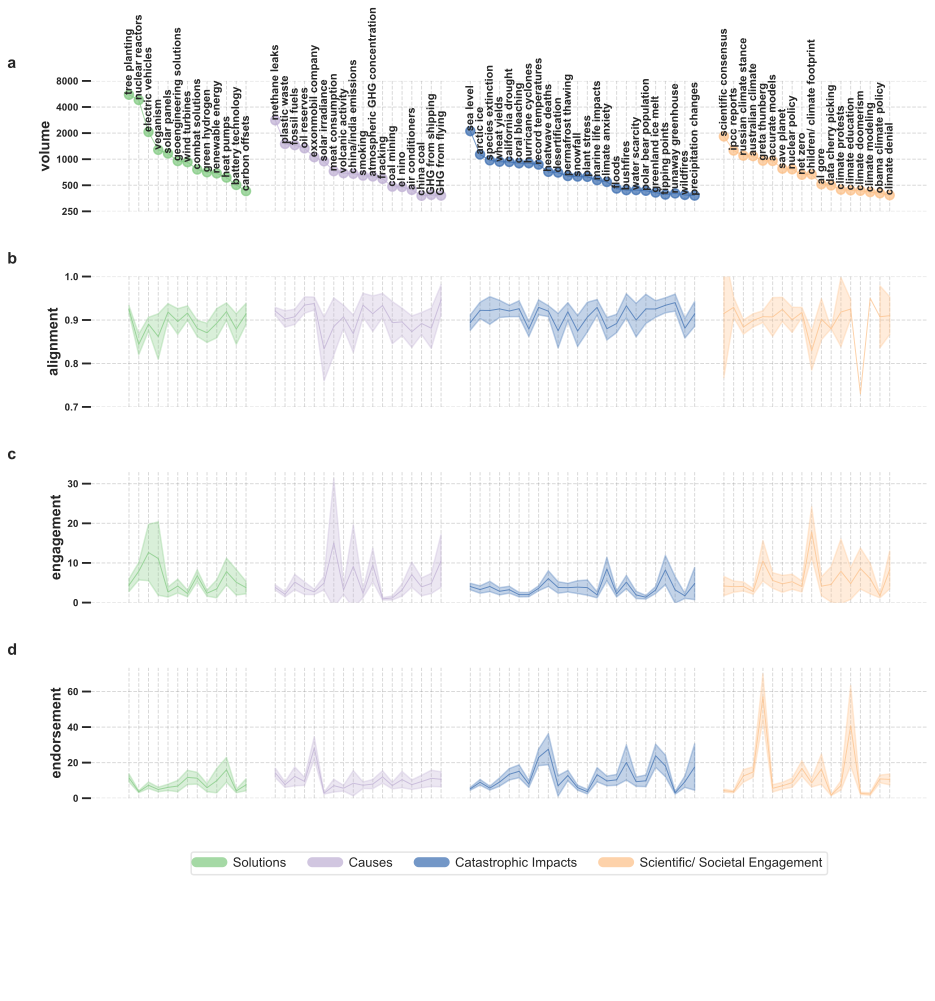

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import gridspec
from scipy import stats

# Theme colors
theme_to_color = {
    'Solutions': '#7fc97f',
    'Causes': '#beaed4', 
    'Catastrophic Impacts': '#386cb0',
    'Scientific/ Societal Engagement': '#fdc086'
}

# Dictionary to store all KS test results
ks_test_results = {
    'Alignment': {},
    'Engagement': {},
    'Attention': {}
}

# Filter out the combat solutions topic
topics_to_exclude = []

# Create figure with 4 rows (one for each metric plus volume)
fig = plt.figure(figsize=(15, 20))
gs = gridspec.GridSpec(6, 1, figure=fig, hspace=0.5)  # Increased rows for legend and volume

# Get all theme data first
all_theme_data = []
for theme in classified_topics.keys():
    theme_data = df_joint_w_topics[df_joint_w_topics['theme'] == theme]
    theme_data = theme_data[~theme_data['Name'].isin(topics_to_exclude)]
    all_theme_data.append(theme_data)

# Track x positions for vertical gridlines
gridline_positions = []

# First row: Volume (total count per topic)
ax4 = fig.add_subplot(gs[0])
ax4.text(-0.1, 1.1, 'a', transform=ax4.transAxes, fontsize=16, fontweight='bold')
x_pos = 0
for theme, theme_data in zip(classified_topics.keys(), all_theme_data):
    positions = []
    volumes = []
    
    for topic_num, topic_group in theme_data.groupby('Topic'):
        volume = len(topic_group)  # Total count for this topic
        volumes.append(volume)
        positions.append(x_pos)
        ax4.text(x_pos, volume, pretty_name[topic_group['Name'].iloc[0]], 
                rotation=90, ha='center', va='bottom', fontsize=11, weight='bold')
        gridline_positions.append(x_pos)  # Store position for gridlines
        x_pos += 1
    
    ax4.plot(positions, volumes, color=theme_to_color[theme], alpha=0.7, linewidth=1)
    ax4.scatter(positions, volumes, color=theme_to_color[theme], alpha=0.7)
    x_pos += 2

# Add vertical gridlines
for pos in gridline_positions:
    ax4.axvline(x=pos, color='gray', alpha=0.3, linestyle='--', linewidth=1, zorder=0)

ax4.set_xticks([])
ax4.set_ylabel('volume', weight='bold', fontsize=14.5)
ax4.set_yscale('log', base=2)
ax4.yaxis.set_major_formatter(plt.ScalarFormatter(useMathText=True))
ax4.grid(True, alpha=0.3, linestyle='--', color='gray', axis='y', linewidth=1)
ax4.set_facecolor('white')
ax4.set_yticks([250,500,1000,2000,4000,8000])
ax4.tick_params(axis='both', which='major', labelsize=10)
for label in ax4.get_yticklabels():
    label.set_weight('bold')

for spine in ax4.spines.values():
    spine.set_visible(False)

# Second row: Mean upvote ratios (Alignment)
ax1 = fig.add_subplot(gs[1])
ax1.text(-0.1, 1.1, 'b', transform=ax1.transAxes, fontsize=16, fontweight='bold')
x_pos = 0
for theme, theme_data in zip(classified_topics.keys(), all_theme_data):
    topic_means = []
    topic_cis = []
    positions = []
    topic_ratios = []  # Store ratios for KS test
    topic_names = []  # Store topic names
    
    for topic_num, topic_group in theme_data.groupby('Topic'):
        filtered_group = topic_group[topic_group['score'] >= 5]
        ratios = filtered_group['upvote_ratio'].dropna()
        topic_ratios.append(ratios)
        topic_names.append(pretty_name[topic_group['Name'].iloc[0]])
        mean_ratio = ratios.mean()
        ci_ratio = 1.96 * stats.sem(ratios)  # 95% confidence interval
        topic_means.append(mean_ratio)
        topic_cis.append(ci_ratio)
        positions.append(x_pos)
        x_pos += 1
    
    # Store KS tests between all pairs
    for i in range(len(topic_ratios)):
        for j in range(i+1, len(topic_ratios)):
            stat, pval = stats.ks_2samp(topic_ratios[i], topic_ratios[j])
            pair_key = f"{theme}_{topic_names[i]}_{topic_names[j]}"
            ks_test_results['Alignment'][pair_key] = {'statistic': stat, 'pvalue': pval}
    
    ax1.plot(positions, topic_means, color=theme_to_color[theme], alpha=0.7, linewidth=1)
    ax1.fill_between(positions,
                     np.array(topic_means) - np.array(topic_cis),
                     np.array(topic_means) + np.array(topic_cis),
                     color=theme_to_color[theme], alpha=0.3)
    x_pos += 2

# Add vertical gridlines
for pos in gridline_positions:
    ax1.axvline(x=pos, color='gray', alpha=0.3, linestyle='--', linewidth=1, zorder=0)

ax1.set_xticks([])
ax1.set_ylabel('alignment', weight='bold', fontsize=14.5)
ax1.set_ylim(0.7, 1.0)
ax1.set_yticks([0.7,0.8, 0.9, 1.0])
ax1.grid(True, alpha=0.3, linestyle='--', color='gray', axis='y', linewidth=1)
ax1.set_facecolor('white')
for spine in ax1.spines.values():
    spine.set_visible(False)
ax1.tick_params(axis='both', which='major', labelsize=10)
for label in ax1.get_yticklabels():
    label.set_weight('bold')

# Third row: Mean number of comments (Engagement)
ax2 = fig.add_subplot(gs[2])
ax2.text(-0.1, 1.1, 'c', transform=ax2.transAxes, fontsize=16, fontweight='bold')
x_pos = 0
for theme, theme_data in zip(classified_topics.keys(), all_theme_data):
    topic_means = []
    topic_cis = []
    positions = []
    topic_comments = []  # Store comments for KS test
    topic_names = []  # Store topic names
    
    for topic_num, topic_group in theme_data.groupby('Topic'):
        comments = topic_group['num_comments'].dropna()
        topic_comments.append(comments)
        topic_names.append(pretty_name[topic_group['Name'].iloc[0]])
        mean_comments = comments.mean()
        ci_comments = 1.96 * stats.sem(comments)  # 95% confidence interval
        topic_means.append(mean_comments)
        topic_cis.append(ci_comments)
        positions.append(x_pos)
        x_pos += 1
    
    # Store KS tests between all pairs
    for i in range(len(topic_comments)):
        for j in range(i+1, len(topic_comments)):
            stat, pval = stats.ks_2samp(topic_comments[i], topic_comments[j])
            pair_key = f"{theme}_{topic_names[i]}_{topic_names[j]}"
            ks_test_results['Engagement'][pair_key] = {'statistic': stat, 'pvalue': pval}
    
    ax2.plot(positions, topic_means, color=theme_to_color[theme], alpha=0.7, linewidth=1)
    ax2.fill_between(positions,
                     np.array(topic_means) - np.array(topic_cis),
                     np.array(topic_means) + np.array(topic_cis),
                     color=theme_to_color[theme], alpha=0.3)
    x_pos += 2

# Add vertical gridlines
for pos in gridline_positions:
    ax2.axvline(x=pos, color='gray', alpha=0.3, linestyle='--', linewidth=1, zorder=0)

ax2.set_xticks([])
ax2.set_ylabel('engagement', weight='bold', fontsize=14.5)
ax2.set_ylim(bottom=0)  # Start y-axis from 0
ax2.grid(True, alpha=0.3, linestyle='--', color='gray', axis='y', linewidth=1)
ax2.set_facecolor('white')
for spine in ax2.spines.values():
    spine.set_visible(False)
ax2.tick_params(axis='both', which='major', labelsize=10)
for label in ax2.get_yticklabels():
    label.set_weight('bold')

# Fourth row: Mean scores (Attention)
ax3 = fig.add_subplot(gs[3])
ax3.text(-0.1, 1.1, 'd', transform=ax3.transAxes, fontsize=16, fontweight='bold')
x_pos = 0
theme_positions = []
theme_labels = []
for theme_idx, (theme, theme_data) in enumerate(zip(classified_topics.keys(), all_theme_data)):
    topic_means = []
    topic_cis = []
    topic_labels = []
    positions = []
    topic_scores = []  # Store scores for KS test
    topic_names = []  # Store topic names
    
    for topic_num, topic_group in theme_data.groupby('Topic'):
        topic_group['date'] = topic_group['created_utc_'].combine_first(topic_group['author_created_utc_'])
        scores = topic_group['score'].dropna()
        topic_scores.append(scores)
        topic_name = pretty_name[topic_group['Name'].iloc[0]]
        topic_names.append(topic_name)
        mean_score = scores.mean()
        ci_score = 1.96 * stats.sem(scores)  # 95% confidence interval
        topic_means.append(mean_score)
        topic_cis.append(ci_score)
        topic_labels.append(topic_name)
        positions.append(x_pos)
        x_pos += 1
    
    # Store KS tests between all pairs
    for i in range(len(topic_scores)):
        for j in range(i+1, len(topic_scores)):
            stat, pval = stats.ks_2samp(topic_scores[i], topic_scores[j])
            pair_key = f"{theme}_{topic_names[i]}_{topic_names[j]}"
            ks_test_results['Attention'][pair_key] = {'statistic': stat, 'pvalue': pval}
    
    ax3.plot(positions, topic_means, color=theme_to_color[theme], alpha=0.7, linewidth=1)
    ax3.fill_between(positions,
                     np.array(topic_means) - np.array(topic_cis),
                     np.array(topic_means) + np.array(topic_cis),
                     color=theme_to_color[theme], alpha=0.3)
    theme_positions.append(np.mean(positions))
    theme_labels.append(theme)
    x_pos += 2

# Add vertical gridlines
for pos in gridline_positions:
    ax3.axvline(x=pos, color='gray', alpha=0.3, linestyle='--', linewidth=1, zorder=0)

ax3.set_xticks([])
ax3.set_ylabel('endorsement', weight='bold', fontsize=14.5)
ax3.set_ylim(bottom=0)
ax3.grid(True, alpha=0.3, linestyle='--', color='gray', axis='y', linewidth=1)
ax3.set_facecolor('white')
for spine in ax3.spines.values():
    spine.set_visible(False)
ax3.tick_params(axis='both', which='major', labelsize=10)
for label in ax3.get_yticklabels():
    label.set_weight('bold')

# Legend for theme colors
ax5 = fig.add_subplot(gs[4])
for theme, color in theme_to_color.items():
    ax5.plot([], [], color=color, label=theme, linewidth=10, alpha=0.7)
ax5.legend(loc='center', fontsize=13, framealpha=0.5, ncol=4, bbox_to_anchor=(0.5, 1))
ax5.axis('off')

plt.tight_layout()
plt.savefig('figures/fig1_volume_attention.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/fig1_volume_attention.png', dpi=300, bbox_inches='tight')

### attention as a function of time

In [21]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# from matplotlib import gridspec
# from scipy import stats
# import datetime

# # Theme colors wit
# h different tones for time periods
# theme_to_color = {
#     'Solutions': '#7fc97f',
#     'Causes': '#beaed4', 
#     'Catastrophic Impacts': '#386cb0',
#     'Scientific/ Societal Engagement': '#fdc086'
# }

# # Define time periods
# time_periods = [
#     ('2010-2015', datetime.datetime(2010,1,1), datetime.datetime(2015,12,31)),
#     ('2015-2020', datetime.datetime(2015,1,1), datetime.datetime(2020,12,31)),
#     ('2020-2023', datetime.datetime(2020,1,1), datetime.datetime(2023,12,31))
# ]

# # Alpha values for different time periods
# period_alphas = {
#     '2010-2015': 0.1,
#     '2015-2020': 0.3,
#     '2020-2023': 1.0
# }
# # Filter out the combat solutions topic
# topics_to_exclude = []

# # Create figure with 3 rows (one for each metric)
# fig = plt.figure(figsize=(15, 16))
# gs = gridspec.GridSpec(5, 1, figure=fig, hspace=0.5)

# # Get all theme data first
# all_theme_data = []
# for theme in classified_topics.keys():
#     theme_data = df_joint_w_topics[df_joint_w_topics['theme'] == theme]
#     theme_data = theme_data[~theme_data['Name'].isin(topics_to_exclude)]
#     theme_data['date'] = pd.to_datetime(theme_data['created_utc_'].combine_first(theme_data['author_created_utc_']))
#     all_theme_data.append(theme_data)

# # First row: Mean scores (Attention)
# ax1 = fig.add_subplot(gs[2])
# x_pos = 0
# for theme_idx, (theme, theme_data) in enumerate(zip(classified_topics.keys(), all_theme_data)):
#     positions = []
#     for topic_num, _ in theme_data.groupby('Topic'):
#         positions.append(x_pos)
#         x_pos += 1
    
#     for period_name, start_date, end_date in time_periods:
#         period_data = theme_data[(theme_data['date'] >= start_date) & (theme_data['date'] <= end_date)]
        
#         topic_means = []
#         topic_cis = []
        
#         for topic_num, topic_group in period_data.groupby('Topic'):
#             scores = topic_group['score'].dropna()
#             if len(scores) > 0:
#                 mean_score = scores.mean()
#                 ci = stats.t.interval(0.95, len(scores)-1, loc=mean_score, scale=stats.sem(scores)) if len(scores) > 1 else (mean_score, mean_score)
#             else:
#                 mean_score = np.nan
#                 ci = (np.nan, np.nan)
#             topic_means.append(mean_score)
#             topic_cis.append(ci)
            
#             # Only add labels for the most recent period
#             if '2023'in period_name:
#                 ax1.text(positions[len(topic_means)-1], mean_score, 
#                         pretty_name[topic_group['Name'].iloc[0]], 
#                         rotation=90, ha='center', va='bottom', fontsize=9)
        
#         ax1.plot(positions, topic_means, color=theme_to_color[theme], 
#                 alpha=period_alphas[period_name], linewidth=1, 
#                 label=f'{theme} ({period_name})')
#         ax1.fill_between(positions,
#                         [ci[0] for ci in topic_cis],
#                         [ci[1] for ci in topic_cis],
#                         color=theme_to_color[theme], alpha=period_alphas[period_name]*0.3)
#     x_pos += 2

# ax1.set_xticks([])
# ax1.set_ylabel('endorsement', fontweight='bold')
# ax1.set_ylim(bottom=0)
# ax1.grid(True, alpha=0.3, linestyle='--')
# for spine in ax1.spines.values():
#     spine.set_visible(False)

# # Second row: Mean upvote ratios (Alignment)
# ax2 = fig.add_subplot(gs[0])
# x_pos = 0
# for theme, theme_data in zip(classified_topics.keys(), all_theme_data):
#     positions = []
#     for topic_num, _ in theme_data.groupby('Topic'):
#         positions.append(x_pos)
#         x_pos += 1
        
#     for period_name, start_date, end_date in time_periods:
#         period_data = theme_data[(theme_data['date'] >= start_date) & (theme_data['date'] <= end_date)]
        
#         topic_means = []
#         topic_cis = []
        
#         for topic_num, topic_group in period_data.groupby('Topic'):
#             filtered_group = topic_group[topic_group['score'] >= 5]
#             ratios = filtered_group['upvote_ratio'].dropna()
#             if len(ratios) > 0:
#                 mean_ratio = ratios.mean()
#                 ci = stats.t.interval(0.95, len(ratios)-1, loc=mean_ratio, scale=stats.sem(ratios)) if len(ratios) > 1 else (mean_ratio, mean_ratio)
#             else:
#                 mean_ratio = np.nan
#                 ci = (np.nan, np.nan)
#             topic_means.append(mean_ratio)
#             topic_cis.append(ci)
            
#             if '2023'in period_name:
#                 ax2.text(positions[len(topic_means)-1], mean_ratio, 
#                         pretty_name[topic_group['Name'].iloc[0]], 
#                         rotation=90, ha='center', va='bottom', fontsize=9)
        
#         ax2.plot(positions, topic_means, color=theme_to_color[theme], 
#                 alpha=period_alphas[period_name], linewidth=1)
#         ax2.fill_between(positions,
#                         [ci[0] for ci in topic_cis],
#                         [ci[1] for ci in topic_cis],
#                         color=theme_to_color[theme], alpha=period_alphas[period_name]*0.3)
#     x_pos += 2

# ax2.set_xticks([])
# ax2.set_ylabel('alignment', fontweight='bold')
# ax2.set_ylim(0.8, 1.0)
# ax2.set_yticks([0.8, 0.9, 1.0])
# ax2.grid(True, alpha=0.3, linestyle='--')
# for spine in ax2.spines.values():
#     spine.set_visible(False)

# # Third row: Mean number of comments (Engagement)
# ax3 = fig.add_subplot(gs[1])
# x_pos = 0
# for theme, theme_data in zip(classified_topics.keys(), all_theme_data):
#     positions = []
#     for topic_num, _ in theme_data.groupby('Topic'):
#         positions.append(x_pos)
#         x_pos += 1
        
#     for period_name, start_date, end_date in time_periods:
#         period_data = theme_data[(theme_data['date'] >= start_date) & (theme_data['date'] <= end_date)]
        
#         topic_means = []
#         topic_cis = []
        
#         for topic_num, topic_group in period_data.groupby('Topic'):
#             comments = topic_group['num_comments'].dropna()
#             if len(comments) > 0:
#                 mean_comments = comments.mean()
#                 ci = stats.t.interval(0.95, len(comments)-1, loc=mean_comments, scale=stats.sem(comments)) if len(comments) > 1 else (mean_comments, mean_comments)
#             else:
#                 mean_comments = np.nan
#                 ci = (np.nan, np.nan)
#             topic_means.append(mean_comments)
#             topic_cis.append(ci)
            
#             if '2023'in period_name:
#                 ax3.text(positions[len(topic_means)-1], mean_comments, 
#                         pretty_name[topic_group['Name'].iloc[0]], 
#                         rotation=90, ha='center', va='bottom', fontsize=9)
        
#         ax3.plot(positions, topic_means, color=theme_to_color[theme], 
#                 alpha=period_alphas[period_name], linewidth=1)
#         ax3.fill_between(positions,
#                         [ci[0] for ci in topic_cis],
#                         [ci[1] for ci in topic_cis],
#                         color=theme_to_color[theme], alpha=period_alphas[period_name]*0.3)
#     x_pos += 2

# ax3.set_xticks([])
# ax3.set_ylabel('engagement', fontweight='bold')
# ax3.grid(True, alpha=0.3, linestyle='--')
# for spine in ax3.spines.values():
#     spine.set_visible(False)

# # Legend
# ax4 = fig.add_subplot(gs[3])
# for theme, color in theme_to_color.items():
#     for period_name, _, _ in time_periods:
#         ax4.plot([], [], color=color, alpha=period_alphas[period_name], 
#                 label=f'{theme} ({period_name})', linewidth=2)
# ax4.legend(loc='center', fontsize=10, framealpha=0.5, ncol=4, bbox_to_anchor=(0.5, 0.5))
# ax4.axis('off')

# plt.tight_layout()
# plt.savefig('figures/fig_combined_metrics_lines_by_period.pdf', dpi=300, bbox_inches='tight')
# plt.savefig('figures/fig_combined_metrics_lines_by_period.png', dpi=300, bbox_inches='tight')

# Fig 2: Network of topics

In [22]:
df=df_joint_w_topics[df_joint_w_topics['theme'].notnull()]
import itertools

topic_edgelist = (df.groupby('link_id')['Name']
                  .apply(lambda x: pd.Series(list(itertools.combinations(x.unique(), 2))))
                  .reset_index(name='node_pairs'))

topic_edgelist[['node1', 'node2']] = topic_edgelist['node_pairs'].apply(pd.Series)
topic_edgelist['weight'] = topic_edgelist.groupby(['node1', 'node2'])['link_id'].transform('count')
topic_edgelist = topic_edgelist[['node1', 'node2', 'weight']].drop_duplicates()
topic_edgelist = topic_edgelist[topic_edgelist['node1'] != topic_edgelist['node2']]


import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import networkx as nx
import matplotlib.pyplot as plt
from adjustText import adjust_text
# Theme colors
import matplotlib.patches as mpatches

theme_to_color = {
    'Solutions': '#7fc97f',
    'Causes': '#beaed4', 
    'Catastrophic Impacts': '#386cb0',
    'Scientific/ Societal Engagement': '#fdc086'
}

# Create dummy patches for theme legend
theme_legend_patches = [mpatches.Patch(color=color, label=theme) for theme, color in theme_to_color.items()]

# Create dummy patches for edge weight legend
edge_weight_legend_patches = [
    mpatches.Patch(color='grey', label='Weight > 3'),
    mpatches.Patch(color='lightgrey', label='Weight <= 3')
]

# Add legends to the plot
#beaed4
#fdc086
#ffff99
# Create a directed graph from the edge list, filtering out edges with weight <= 5
topic_edgelist_filtered = topic_edgelist[topic_edgelist['weight'] > 0]
# Remove 'software engineering' and 'fight_combat_fix_solutions' from the topics
topic_edgelist_filtered = topic_edgelist_filtered[~topic_edgelist_filtered['node1'].str.contains('software|31_fight_combat_fix_solutions', case=False)]
topic_edgelist_filtered = topic_edgelist_filtered[~topic_edgelist_filtered['node2'].str.contains('software|31_fight_combat_fix_solutions', case=False)]
G = nx.from_pandas_edgelist(topic_edgelist_filtered, 'node1', 'node2', ['weight'])

# Calculate quartiles for edge weights
weights = list(nx.get_edge_attributes(G, 'weight').values())
q1, q2, q3 = np.percentile(weights, [25, 50, 75])
max_weight = max(weights)

# Create custom colormap for edges
colors = plt.cm.Greys(np.linspace(0, 1, 4))  # Using a mono color map (Greyscale)
edge_cmap = LinearSegmentedColormap.from_list('custom', colors)

# Set node colors based on themes
node_colors = [theme_to_color[name_to_theme[node]] for node in G.nodes() if node in name_to_theme]

# Detect core-periphery structure using weighted k-shell decomposition
def weighted_k_shell(G):
    # Create a copy of the graph to work with
    H = G.copy()
    shell_index = {}
    k = 1
    
    while H.nodes():
        # Calculate weighted degree for remaining nodes
        weighted_degrees = dict(H.degree(weight='weight'))
        
        # Find nodes with minimum weighted degree
        min_degree = min(weighted_degrees.values())
        shell_nodes = [n for n, d in weighted_degrees.items() if d <= min_degree]
        
        # Assign shell index to nodes
        for node in shell_nodes:
            shell_index[node] = k
            
        # Remove nodes in current shell
        H.remove_nodes_from(shell_nodes)
        k += 1
    
    return shell_index

# Get core-periphery structure
shell_indices = weighted_k_shell(G)
r = 1

# Calculate node strengths
node_strengths = dict(G.degree(weight='weight'))
max_strength = max(node_strengths.values())

# Network plot (Fig 2)
plt.figure(figsize=(15, 12.375), dpi=300)

# Get initial spring layout positions
initial_pos = nx.spring_layout(G, k=1, iterations=50)

# Calculate new positions based on shell numbers
pos = {}
num_shells = max(shell_indices.values())

for node in G.nodes():
    # Get initial x,y coordinates
    x, y = initial_pos[node]
    
    # Calculate angle from initial position
    angle = np.arctan2(y, x)
    
    # Set radius based on shell number (max_shell - shell_number + 1)
    radius = np.sqrt(num_shells - shell_indices[node]) + r  # Similar radius form

    # Calculate new position
    pos[node] = (radius * np.cos(angle), radius * np.sin(angle))

# Draw edges with transparency based on weight
for (u, v, w) in G.edges(data='weight'):
    nx.draw_networkx_edges(G, pos, 
                          edgelist=[(u,v)],
                          width=1*w/max_weight,
                          alpha=0.08,
                          edge_color='grey')

# Draw nodes colored by theme and sized by strength
for shell in range(1, num_shells + 1):
    shell_nodes = [node for node, index in shell_indices.items() if index == shell]
    
    for node in shell_nodes:
        theme = name_to_theme[node]
        
        if theme in theme_to_color:
            node_size = 625 * node_strengths[node]/max_strength
            nx.draw_networkx_nodes(G, pos,
                                 nodelist=[node],
                                 node_color=[theme_to_color[theme]],
                                 node_size=node_size,
                                 alpha=0.8,
                                 edgecolors='white',
                                 linewidths=0.6)
# Draw concentric circles for every 5th shell with shell numbers
max_radius = num_shells
for shell in range(1, num_shells + 1):
    if shell % 5 == 0:  # Only plot every 5th shell
        radius = np.sqrt(max_radius - shell) + r
        circle = plt.Circle((0, 0), radius, fill=False, linestyle='--', alpha=0.7, color='indianred')
        plt.gca().add_artist(circle)
        
        # Add shell number label
        angle = np.pi/8  # Position at 45 degrees
        x = radius * np.cos(angle)
        y = radius * np.sin(angle)
        plt.text(x, y, f'{shell}', fontsize=10, alpha=0.7, color='indianred', weight='bold',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))

# Add labels with adjusted positioning to avoid overlap
texts = []
for node in G.nodes():
    x, y = pos[node]
    texts.append(plt.text(x, y, pretty_name[node],
                         fontsize=15.2,
                         ha='center', 
                         va='center',
                         weight='bold'))

# First pass of adjust_text
a=.1    

adjust_text(texts,
           force_text=(a, a),
           expand_points=(a+1, a+1),
           expand_text=(a+1, a+1),
           arrowprops=dict(arrowstyle='-', color='k', lw=0.05,alpha=0.4),
           only_move={'points':'xy', 'texts':'xy'})


# Post-process text positions - lift overlapping labels
ax = plt.gca()
y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
lift_amount = 0.4 * y_range

# Check for overlaps and lift labels
for i, text in enumerate(texts):
    for j in range(i+1, len(texts)):
        pos1 = text.get_position()
        pos2 = texts[j].get_position()
        dist = np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)
        if dist < 0.5:
            new_pos = (pos1[0], pos1[1] + lift_amount)
            text.set_position(new_pos)
            adjust_text([text],
                       force_points=(a, a),
                       force_text=(a, a),
                       expand_points=(a, a),
                       expand_text=(a, a),
                       )

plt.axis('equal')
plt.axis('off')
plt.tight_layout()
plt.savefig('figures/fig2_network.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.savefig('figures/fig2_network.png', format='png', bbox_inches='tight', dpi=300)
plt.close()


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


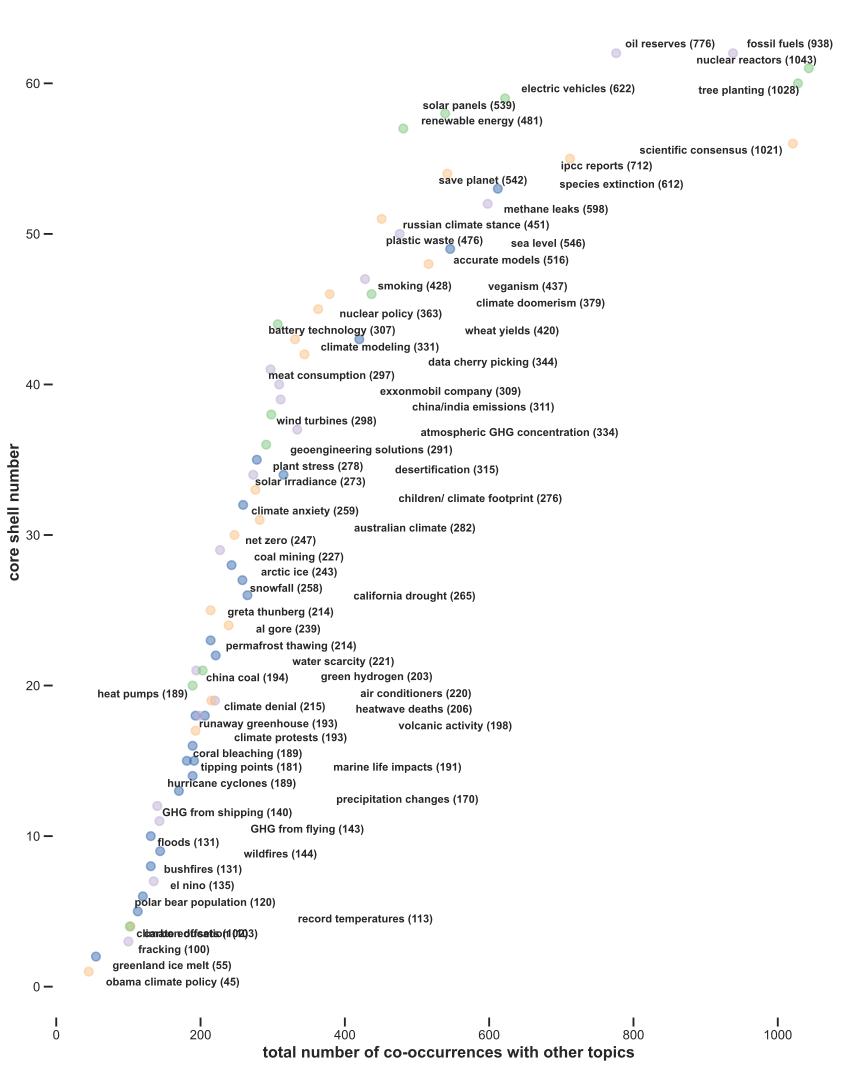

In [23]:
# Create dataframe with shell indices and node strengths
shell_data = pd.DataFrame.from_dict(shell_indices, orient='index', columns=['shell'])
shell_data['node'] = shell_data.index
shell_data = shell_data[shell_data.index != '29_software_engineering_career_engineer']

# Add node strengths and themes
node_strengths = {node: G.degree(node, weight='weight') for node in G.nodes()}
shell_data['strength'] = shell_data['node'].map(node_strengths)
shell_data['theme'] = shell_data['node'].map(name_to_theme)
shell_data['color'] = shell_data['theme'].map(theme_to_color)
shell_data['name'] = shell_data['node'].map(pretty_name)

# Group by shell and calculate mean strength
shell_strengths = shell_data.groupby(['shell', 'theme', 'color', 'name'])['strength'].mean().reset_index()
shell_strengths = shell_strengths.sort_values('shell')

# Supplementary scatter plot
plt.figure(figsize=(12, 15), dpi=300)

# Create scatter plot with points - vertical orientation
plt.scatter(shell_strengths['strength'], shell_strengths['shell'],
           c=shell_strengths['color'], alpha=0.5, s=75)

# Customize axes
plt.ylabel('core shell number', fontsize=16, weight='bold')
plt.xlabel('total number of co-occurrences with other topics', fontsize=16, weight='bold')
plt.tick_params(axis='both', which='major', labelsize=13)

plt.grid(False)

# Add all topic names and values
texts = []
points = []

for _, row in shell_strengths.iterrows():
    points.append((row['strength'], row['shell']))
    texts.append(plt.text(row['strength'], row['shell'],
                         f" {row['name']} ({int(row['strength'])})",
                         ha='left', va='center', fontsize=11, weight='bold'))
# Mild text adjustment parameters
adjust_text(texts,
           force_points=(0.05, 0.05), 
           force_text=(0.05, 0.05),
           expand_points=(1.2, 1.2),
           expand_text=(1.2, 1.2))

# Remove spines
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.gca().set_facecolor('white')

# Create legend for themes
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=color, label=theme,
                             markersize=7.5)
                  for theme, color in theme_to_color.items() if theme in theme_to_color]

plt.tight_layout()
plt.savefig('figures/fig_SI_network.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.savefig('figures/fig_SI_network.png', format='png', bbox_inches='tight', dpi=300)


In [24]:
# Compare total nodes in network to total topics
print(f"Total nodes in network: {len(G.nodes())}")
print(f"Total topics (from topic modeling): {len(shell_data)}")


Total nodes in network: 72
Total topics (from topic modeling): 72


In [25]:
# Print total co-occurrences for each topic in descending order
print("Total co-occurrences by topic:")
print("------------------------------")
sorted_strengths = shell_strengths.sort_values('strength', ascending=False)
for _, row in sorted_strengths.iterrows():
    print(f"{row['name']}: {int(row['strength'])}")


Total co-occurrences by topic:
------------------------------
nuclear reactors: 1043
tree planting: 1028
scientific consensus: 1021
fossil fuels: 938
oil reserves: 776
ipcc reports: 712
electric vehicles: 622
species extinction: 612
methane leaks: 598
sea level: 546
save planet: 542
solar panels: 539
accurate models: 516
renewable energy: 481
plastic waste: 476
russian climate stance: 451
veganism: 437
smoking: 428
wheat yields: 420
climate doomerism: 379
nuclear policy: 363
data cherry picking: 344
atmospheric GHG concentration: 334
climate modeling: 331
desertification: 315
china/india emissions: 311
exxonmobil company: 309
battery technology: 307
wind turbines: 298
meat consumption: 297
geoengineering solutions: 291
australian climate: 282
plant stress: 278
children/ climate footprint: 276
solar irradiance: 273
california drought: 265
climate anxiety: 259
snowfall: 258
net zero: 247
arctic ice: 243
al gore: 239
coal mining: 227
water scarcity: 221
air conditioners: 220
climate denia

In [26]:
# Import spearmanr
from scipy.stats import spearmanr

# Get topic volumes
topic_volumes = {}
for theme in classified_topics.keys():
    theme_data = df_joint_w_topics[df_joint_w_topics['theme'] == theme]
    theme_data = theme_data[~theme_data['Name'].isin(topics_to_exclude)]
    for topic_num, topic_group in theme_data.groupby('Topic'):
        topic_name = topic_group['Name'].iloc[0]
        topic_volumes[topic_name] = len(topic_group)

# Map pretty names to topic names first, then map volumes 
shell_data['volume'] = shell_data['node'].map(topic_volumes)

# Calculate Spearman correlation between shell number and volume
volume_data = shell_data.dropna(subset=['volume'])  # Remove NaN volumes
corr_coef, p_value = spearmanr(volume_data['shell'], volume_data['volume'])
print(f"Spearman correlation (shell vs volume): rho={corr_coef:.3f}, p={p_value:.3e}")

# Supplementary scatter plot - Topic Volume
plt.figure(figsize=(12, 15), dpi=300)

# Create scatter plot with points - vertical orientation
plt.scatter(shell_data['volume'], shell_data['shell'],
           c=shell_data['color'], alpha=0.5, s=75)

# Customize axes
plt.ylabel('core shell number', fontsize=16, weight='bold')
plt.xlabel('topic volume (number of comments)', fontsize=16, weight='bold')
plt.tick_params(axis='both', which='major', labelsize=13)
plt.xscale('log')
plt.gca().xaxis.set_major_locator(plt.LogLocator(numticks=10))

plt.grid(False)

# Add all topic names and values
texts = []
points = []

for _, row in shell_data.iterrows():
    if pd.notna(row['volume']):  # Only add text if volume is not NaN
        points.append((row['volume'], row['shell']))
        texts.append(plt.text(row['volume'], row['shell'],
                            f" {row['name']} ({int(row['volume'])})",
                            ha='left', va='center', fontsize=11, weight='bold'))

# Mild text adjustment parameters
adjust_text(texts,
           force_points=(0.05, 0.05), 
           force_text=(0.05, 0.05),
           expand_points=(1.2, 1.2),
           expand_text=(1.2, 1.2))

# Remove spines
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.gca().set_facecolor('white')

# Create legend for themes
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=color, label=theme,
                             markersize=7.5)
                  for theme, color in theme_to_color.items() if theme in theme_to_color]

plt.tight_layout()
plt.savefig('figures/fig_SI_network_volume.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.savefig('figures/fig_SI_network_volume.png', format='png', bbox_inches='tight', dpi=300)
plt.close()

Spearman correlation (shell vs volume): rho=0.716, p=1.540e-12


# Fig 4: emotions

In [ ]:
from transformers import pipeline
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", tokenizer="SamLowe/roberta-base-go_emotions", max_length=512, truncation=True, top_k=None)

def data_cleaning(sentence):
        """
        This function cleans sentences with the help of regex. URLs and hashtags are removed.
        :param sent: Sentence to be cleaned
        :return: Returns cleaned sentence after Lemmatization
        """
        texts = sentence.lower()
        texts = re.sub('[^a-z0-9]', ' ', texts)
        texts = re.sub(r'http\S+', '', texts)  # Remove URLs
        texts = re.sub(r'@[A-Za-z0-9]+', '', texts)  # Remove user mentions
        texts = re.sub(r'#[A-Za-z0-9]+', '', texts)  # Remove hashtags
        texts = re.sub(r'[^a-zA-Z\s]', '', texts)  # Remove non-alphabetic characters
        # words = tokenizer.word_tokenize(texts)
        # words = [word for word in words if word not in stopwords.words('english')]  # Remove stopwords
        # words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatization
        # return ' '.join(words)
        return texts


Device set to use cpu


Topic: tree planting, % comments with neutral emotion: 56.98%
Topic: nuclear reactors, % comments with neutral emotion: 51.93%
Topic: electric vehicles, % comments with neutral emotion: 53.40%
Topic: solar panels, % comments with neutral emotion: 62.25%
Topic: geoengineering solutions, % comments with neutral emotion: 53.47%
Topic: wind turbines, % comments with neutral emotion: 67.21%
Topic: combat solutions, % comments with neutral emotion: 38.95%
Topic: veganism, % comments with neutral emotion: 35.26%
Topic: green hydrogen, % comments with neutral emotion: 63.93%
Topic: renewable energy, % comments with neutral emotion: 53.06%
Topic: heat pumps, % comments with neutral emotion: 57.10%
Topic: battery technology, % comments with neutral emotion: 61.51%
Topic: carbon offsets, % comments with neutral emotion: 60.05%
Topic: methane leaks, % comments with neutral emotion: 67.43%
Topic: fossil fuels, % comments with neutral emotion: 54.65%
Topic: oil reserves, % comments with neutral emot

C:\Users\chowdhary\AppData\Local\Temp\ipykernel_43948\2305522483.py:171: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\chowdhary\AppData\Local\Temp\ipykernel_43948\2305522483.py:171: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


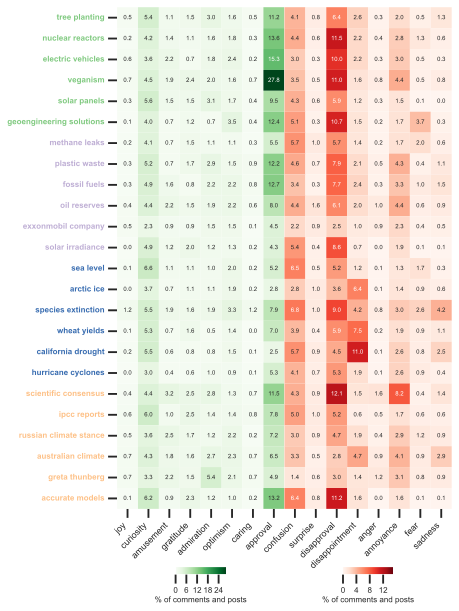

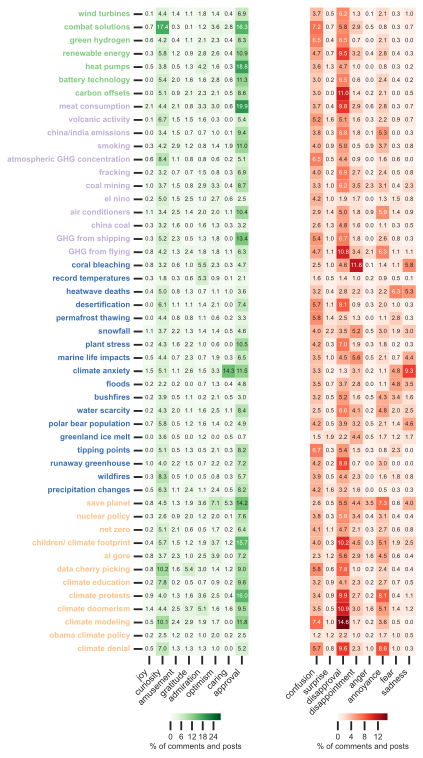

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import seaborn as sns
threshold_emo = .3

# Load the emotions model outputs
emotion_data = {}

# Define positive, negative, and neutral emotions
positive_emotions = ['joy', 'curiosity','amusement', 'gratitude', 'admiration', 'optimism', 'caring', 'approval']
negative_emotions = ['confusion', 'surprise', 'disapproval', 'disappointment', 'anger', 'annoyance', 'fear', 'sadness']
neutral_emotions = ['neutral']  # Assuming 'neutral' is the label for neutral emotions
dict_neutral={}

# Load and process emotion data
for theme in classified_topics.keys():
    dict_neutral[theme]={}
    topics = list(classified_topics[theme].keys())
    for topic_name in topics:
        try:
            file_path = 'data/emotions_model_outputs_local' + str(topic_name) + '.pkl'
            if os.path.exists(file_path):
                with open(file_path, 'rb') as f:
                    model_outputs = pickle.load(f)
            else:
                file_path = 'data/emotions_model_outputs_' + str(topic_name) + '.pkl'
                with open(file_path, 'rb') as f:
                    model_outputs = pickle.load(f)
        except:
            # Run emotion classification if files not found
            sentences = list(df_joint_w_topics[df_joint_w_topics['Name'] == topic_name]['body'])
            sentences = [data_cleaning(sentence) for sentence in sentences]

            T0 = time.time()
            model_outputs = []
            for i in range(0, len(sentences), 15):
                batch = sentences[i:i + 15]
                outputs = classifier(batch)
                model_outputs.extend(outputs)
                progress = (i + len(batch)) / len(sentences) * 100
                
                T1 = time.time()
                elapsed_time = (T1 - T0) / 60
                print(f"Progress: {progress:.2f}% completed for {topic_name}, elapsed: {elapsed_time:.2f} minutes", end='\r')

            with open(f'data/emotions_model_outputs_{topic_name}.pkl', 'wb') as f:
                pickle.dump(model_outputs, f)

        # Count comments with emotions above threshold
        emo_counts = {}
        total_comments = len(model_outputs)
        
        for comment_outputs in model_outputs:
            for emotion_output in comment_outputs:
                emo = emotion_output['label']
                if emotion_output['score'] >= threshold_emo:
                    emo_counts[emo] = emo_counts.get(emo, 0) + 1
        
        # Calculate percentage of comments with each emotion
        emo_percentages = {}
        for emo in emo_counts:
            percentage = (emo_counts[emo] / total_comments) * 100
            emo_percentages[emo] = percentage
            
        # Calculate and print percentage of neutral comments
        neutral_count = total_comments - sum(emo_counts.get(emo, 0) for emo in positive_emotions + negative_emotions)
        neutral_percentage = (neutral_count / total_comments) * 100 if total_comments > 0 else 0
        print(f"Topic: {pretty_name[topic_name]}, % comments with neutral emotion: {neutral_percentage:.2f}%")
        dict_neutral[theme][topic_name]=neutral_percentage
        # Store the emotion percentages for each topic
        emotion_data[topic_name] = emo_percentages

# Calculate global max values for consistent colorbar limits
all_pos_values = []
all_neg_values = []
for topic in emotion_data:
    for emotion in positive_emotions:
        all_pos_values.append(emotion_data[topic].get(emotion, 0))
    for emotion in negative_emotions:
        all_neg_values.append(emotion_data[topic].get(emotion, 0))
global_max_pos = np.ceil(max(all_pos_values))
global_max_neg = np.ceil(max(all_neg_values))

# Function to create heatmap
def create_heatmap(ordered_topics, filename=''):
    # Create figure with two side-by-side heatmaps
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 15), gridspec_kw={'wspace':.001})

    # Create data matrices for both heatmaps
    data_matrix_pos = np.zeros((len(ordered_topics), len(positive_emotions)))
    data_matrix_neg = np.zeros((len(ordered_topics), len(negative_emotions)))

    # Fill matrices with percentages
    for i, topic in enumerate(ordered_topics):
        for j, emotion in enumerate(positive_emotions):
            data_matrix_pos[i,j] = emotion_data[topic].get(emotion, 0)
        for j, emotion in enumerate(negative_emotions):
            data_matrix_neg[i,j] = emotion_data[topic].get(emotion, 0)

    # Create positive emotions heatmap
    sns.heatmap(data_matrix_pos,
                xticklabels=positive_emotions,
                yticklabels=[pretty_name[t] for t in ordered_topics],
                cmap='Greens',
                annot=True,
                fmt='.1f',
                cbar_kws={'label': '% of comments and posts',
                         'orientation': 'horizontal',
                         'location': 'bottom',
                         'shrink': 0.3,
                         'aspect': 20,
                         'pad': 0.07},  # Reduced padding between colorbar and heatmap
                square=True,
                annot_kws={"size": 6},
                ax=ax1,
                vmin=0,
                vmax=global_max_pos)

    # Create negative emotions heatmap
    sns.heatmap(data_matrix_neg,
                xticklabels=negative_emotions,
                yticklabels=[],
                cmap='Reds',
                annot=True,
                fmt='.1f',
                cbar_kws={'label': '% of comments and posts',
                         'orientation': 'horizontal',
                         'location': 'bottom',
                         'shrink': 0.3,
                         'aspect': 20,
                         'pad': 0.07},  # Reduced padding between colorbar and heatmap
                square=True,
                annot_kws={"size": 6},
                ax=ax2,
                vmin=0,
                vmax=global_max_neg)

    # Color y-axis labels based on theme
    ytick_labels = ax1.get_yticklabels()
    for i, topic in enumerate(ordered_topics):
        for theme, theme_topics in classified_topics.items():
            if topic in theme_topics:
                color = theme_to_color[theme]
                ytick_labels[i].set_color(color)
                ytick_labels[i].set_fontweight('bold')
                break

    # Customize appearance
    for ax in [ax1, ax2]:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(False)
        
        cbar = ax.collections[0].colorbar
        
        if ax == ax1:
            cbar.ax.set_xlim(0, global_max_pos)
            cbar.ax.set_xticks(np.arange(0, global_max_pos + 1, 6))
        else:
            cbar.ax.set_xlim(0, global_max_neg)
            cbar.ax.set_xticks(np.arange(0, global_max_neg + 1, 4))
            
        cbar.ax.set_box_aspect(0.15)
        cbar.ax.tick_params(labelsize=8)
        cbar.set_label('% of comments and posts', size=8, labelpad=2)

    plt.tight_layout()
    plt.savefig(f'figures/{filename}.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.savefig(f'figures/{filename}.png', format='png', bbox_inches='tight', dpi=300)

# Get top 6 topics by volume for each theme for main figure
top_topics = []
for theme in classified_topics:
    theme_topics = list(classified_topics[theme].keys())
    theme_topics.sort(key=lambda x: topic_volumes[x], reverse=True)
    top_topics.extend(theme_topics[:6])

# Create main figure with top 6 topics from each theme
create_heatmap(top_topics, filename='fig4')
# Get remaining topics for SI figure
remaining_topics = []
for theme in classified_topics:
    theme_topics = list(classified_topics[theme].keys())
    remaining_topics.extend([topic for topic in theme_topics if topic not in top_topics])

# Create SI figure with remaining topics
if remaining_topics:
    create_heatmap(remaining_topics, filename='fig_SI_emo_other_topics')

# Export combined emotion data
combined_emotion_data = {topic: {**{emo: emotion_data[topic].get(emo, 0) for emo in positive_emotions},
                               **{emo: emotion_data[topic].get(emo, 0) for emo in negative_emotions}}
                        for topic in emotion_data.keys()}

with open('combined_emotion_data.txt', 'w') as f:
    for topic, emotions in combined_emotion_data.items():
        f.write(f"{topic}: {emotions}\n")


In [ ]:
df_joint_nuclear.keys()


Index(['author', 'body', 'Topic_name', 'created_utc_', 'author_created_utc_',
       'id', 'controversiality', 'link_id', 'parent_id', 'to_filter_out',
       'Document', 'Topic', 'Representation', 'Representative_Docs',
       'Top_n_words', 'Probability', 'Representative_document', 'upvote_ratio',
       'score'],
      dtype='object')

# Fig 3: emotional charge

C:\Users\chowdhary\AppData\Local\Temp\ipykernel_24772\2695540019.py:21: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axhspan(bin_start, bin_end,


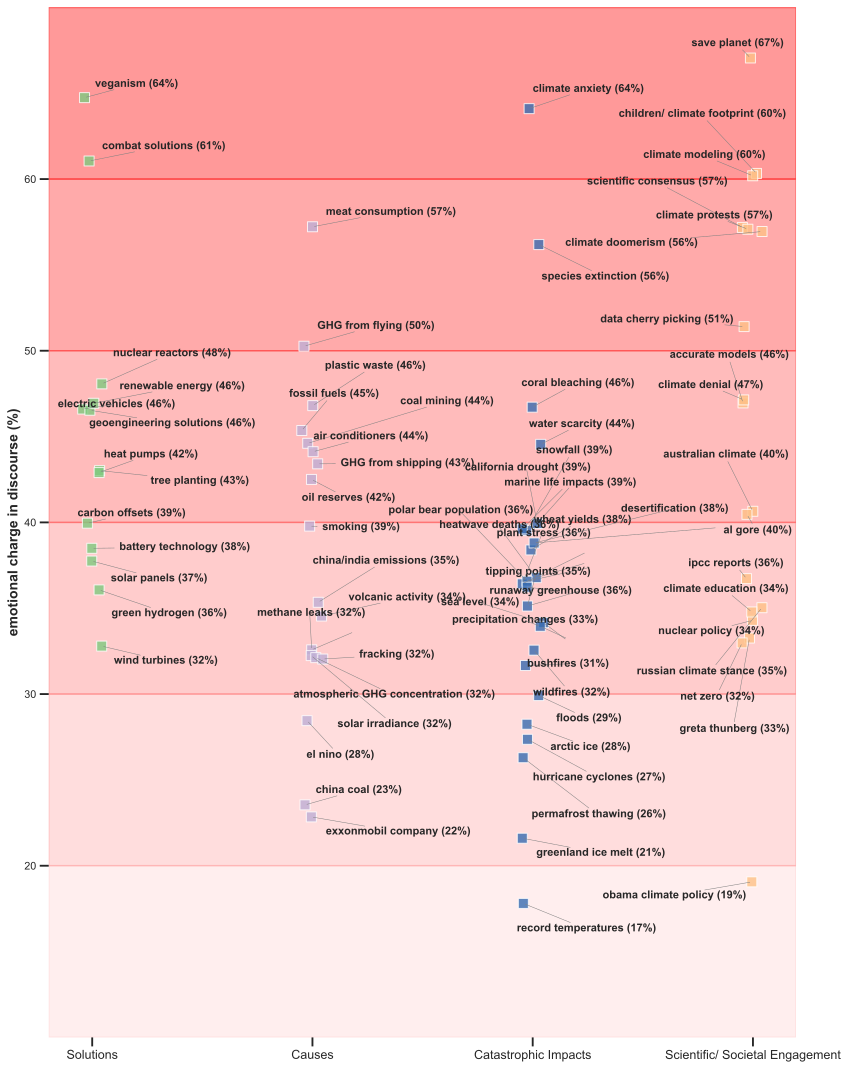

In [61]:
# Create figure for emotional charge plot
plt.figure(figsize=(12, 15), dpi=300)

# Create discrete gradient background
ax = plt.gca()
num_bins = 10  # For 20% intervals
bin_width = 100/num_bins
for i in range(num_bins):
    x_start = i * bin_width
    x_end = (i + 1) * bin_width
    alpha = x_start/150  # Divide by 150 (100/1.5) to normalize
    plt.axhspan(x_start, x_end, 
                xmin=0, xmax=1,
                color='red', 
                alpha=alpha,
                zorder=0)

# Add white borders to highlight bins
bin_ranges = [(0,20), (20,30), (30,40), (40,50), (50,60), (60,70)]
for bin_start, bin_end in bin_ranges:
    plt.axhspan(bin_start, bin_end,
                xmin=0, xmax=1,
                color='none',
                edgecolor='white',
                linewidth=1,
                zorder=1)

# Track x positions for each theme to stagger points
theme_x = {}
x_pos = 0
for theme in theme_to_color:
    theme_x[theme] = x_pos
    x_pos += 1

# Store points and texts for labeling
texts = []
points = []

# Plot points for each theme
for theme, color in theme_to_color.items():
    if theme in dict_neutral:
        # Get topics and neutral percentages for this theme
        topics = list(dict_neutral[theme].keys())
        neutral_pcts = list(dict_neutral[theme].values())
        
        # Calculate emotional charge (100 - neutral%)
        emotional_charges = [100 - n for n in neutral_pcts]
        
        # Create slightly random x positions centered on theme position
        x = [theme_x[theme] + np.random.uniform(-0.05, 0.05) for _ in range(len(topics))]
        
        # Plot points
        plt.scatter(x, emotional_charges, 
                   color=color, 
                   s=100,  # Increased size
                   alpha=0.8,  # Increased alpha
                   marker='s',
                   edgecolor='white',
                   linewidth=1)
        
        # Store points and create labels
        for i in range(len(topics)):
            points.append((x[i], emotional_charges[i]))
            texts.append(plt.text(x[i], emotional_charges[i],
                                f" {pretty_name[topics[i]]} ({int(emotional_charges[i])}%)",
                                ha='left', va='center', 
                                fontsize=11,
                                weight='bold'))

# Use adjust_text to prevent overlap
from adjustText import adjust_text
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# Post-process text positions
ax = plt.gca()
bbox_list = [text.get_window_extent(renderer=plt.gcf().canvas.get_renderer()) for text in texts]
y_range = ax.get_ylim()[1] - ax.get_ylim()[0]
lift_amount = 0.01 * y_range

# Define check_overlap function
def check_overlap(bbox1, bbox2):
    return (bbox1.x0 < bbox2.x1 and bbox1.x1 > bbox2.x0 and
            bbox1.y0 < bbox2.y1 and bbox1.y1 > bbox2.y0)

# Check for overlaps and lift labels
for i, text in enumerate(texts):
    for j in range(i+1, len(texts)):
        if check_overlap(bbox_list[i], bbox_list[j]):
            pos = text.get_position()
            new_pos = (pos[0]-.2, pos[1] + lift_amount)
            text.set_position(new_pos)
            
            if hasattr(text, 'arrow_patch') and text.arrow_patch is not None:
                text.arrow_patch.remove()
            
            text.arrow_patch = plt.annotate('', 
                xy=points[i],
                xytext=new_pos,
                arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
                annotation_clip=False)

# Customize appearance
plt.ylabel('emotional charge in discourse (%)', fontsize=14, weight='bold')

# Set theme names as x-tick labels
plt.xticks(range(len(theme_to_color)), 
           list(theme_to_color.keys()),
           rotation=0,
           ha='center',
           fontsize=12.5)

# Set y-axis limits and ticks
plt.ylim(10, 70)
plt.yticks([20, 30, 40, 50, 60])

# Remove spines
for spine in ['top', 'right', 'left', 'bottom']:
    plt.gca().spines[spine].set_visible(False)

# Set background color
plt.gca().set_facecolor('white')

# Adjust layout
plt.tight_layout()

# Save figures
plt.savefig('figures/fig3_emotional_charge_by_theme.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.savefig('figures/fig3_emotional_charge_by_theme.png', format='png', bbox_inches='tight', dpi=300)

In [62]:
# # Create 6 plots for different emotional charge bins
# bin_ranges = [(0,20), (20,30), (30,40), (40,50), (50,60), (60,80),]

# # Pre-generate random y offsets for each theme and topic that will be reused
# theme_topic_y = {}
# y_pos = 0
# for theme in theme_to_color:
#     if theme in dict_neutral:
#         topics = list(dict_neutral[theme].keys())
#         # Generate random offsets for each topic in this theme
#         theme_topic_y[theme] = {
#             topic: y_pos + np.random.uniform(-0.05, 0.05) 
#             for topic in topics
#         }
#     y_pos += 1

# # Set alpha for non-current bin labels
# faded_alpha = 0.1

# for bin_num, (bin_start, bin_end) in enumerate(bin_ranges):
#     # Create figure for emotional charge plot
#     plt.figure(figsize=(15, 8), dpi=300)

#     # Create discrete gradient background
#     ax = plt.gca()
#     num_bins = 10  # For 20% intervals
#     bin_width = 100/num_bins
#     for i in range(num_bins):
#         x_start = i * bin_width
#         x_end = (i + 1) * bin_width
#         alpha = x_start/150  # Divide by 150 (100/1.5) to normalize
#         plt.axvspan(x_start, x_end, 
#                     ymin=0, ymax=1,
#                     color='red', 
#                     alpha=alpha,
#                     zorder=0)
    
#     # Add white border to highlight current bin
#     plt.axvspan(bin_start, bin_end,
#                 ymin=0, ymax=1,
#                 color='none',
#                 edgecolor='white',
#                 linewidth=2,
#                 zorder=1)

#     # Store points and texts for labeling  
#     texts = []  # For current bin labels only
#     faded_texts = []  # For other bin labels
#     points = []
#     faded_points = []
    
#     # Count points in current bin for font size scaling
#     points_in_bin = 0
#     for theme in theme_to_color:
#         if theme in dict_neutral:
#             emotional_charges = [100 - n for n in dict_neutral[theme].values()]
#             points_in_bin += sum(1 for ec in emotional_charges if bin_start <= ec < bin_end)

#     # Plot points for each theme
#     for theme, color in theme_to_color.items():
#         if theme in dict_neutral:
#             topics = list(dict_neutral[theme].keys())
#             neutral_pcts = list(dict_neutral[theme].values())
#             emotional_charges = [100 - n for n in neutral_pcts]
#             y = [theme_topic_y[theme][topic] for topic in topics]
            
#             plt.scatter(emotional_charges, y,
#                        color=color, 
#                        s=100, 
#                        alpha=0.8,
#                        marker='s',
#                        edgecolor='white',
#                        linewidth=1)
            
#             # Create labels for all points
#             for i in range(len(topics)):
#                 base_font_size = min(15, max(9, 9 * np.exp(emotional_charges[i]/30)))
                
#                 if bin_start <= emotional_charges[i] < bin_end:
#                     points.append((emotional_charges[i], y[i]))
#                     if bin_start == 0:
#                         font_size = base_font_size * 1.4
#                     else:
#                         increase_factor = 1 + (0.4 / max(1, points_in_bin))
#                         font_size = base_font_size * increase_factor
                        
#                     texts.append(plt.text(emotional_charges[i], y[i],
#                                         f" {pretty_name[topics[i]]} ({int(emotional_charges[i])}%)",
#                                         ha='left', va='center', 
#                                         fontsize=font_size,
#                                         weight='bold'))
#                 else:
#                     faded_points.append((emotional_charges[i], y[i]))
#                     faded_texts.append(plt.text(emotional_charges[i], y[i],
#                                               f" {pretty_name[topics[i]]} ({int(emotional_charges[i])}%)",
#                                               ha='left', va='center', 
#                                               fontsize=base_font_size * 0.5,
#                                               weight='bold',
#                                               alpha=faded_alpha))

#     # Handle overlap removal separately for current bin and faded labels
#     if texts:
#         from adjustText import adjust_text
#         adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

#         # Post-process text positions for current bin labels
#         ax = plt.gca()
#         bbox_list = [text.get_window_extent(renderer=plt.gcf().canvas.get_renderer()) for text in texts]
#         x_range = ax.get_xlim()[1] - ax.get_xlim()[0]
#         lift_amount = 0.01 * x_range

#         for i, text in enumerate(texts):
#             for j in range(i+1, len(texts)):
#                 if check_overlap(bbox_list[i], bbox_list[j]):
#                     pos = text.get_position()
#                     new_pos = (pos[0] + lift_amount, pos[1]-.2)
#                     text.set_position(new_pos)
                    
#                     if hasattr(text, 'arrow_patch') and text.arrow_patch is not None:
#                         text.arrow_patch.remove()
                    
#                     text.arrow_patch = plt.annotate('', 
#                         xy=points[i],
#                         xytext=new_pos,
#                         arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
#                         annotation_clip=False)

#     # Handle faded labels overlap separately
#     if faded_texts:
#         adjust_text(faded_texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, alpha=faded_alpha))
        
#         # Post-process faded text positions
#         bbox_list_faded = [text.get_window_extent(renderer=plt.gcf().canvas.get_renderer()) for text in faded_texts]
        
#         for i, text in enumerate(faded_texts):
#             for j in range(i+1, len(faded_texts)):
#                 if check_overlap(bbox_list_faded[i], bbox_list_faded[j]):
#                     pos = text.get_position()
#                     new_pos = (pos[0] + lift_amount, pos[1]-.2)
#                     text.set_position(new_pos)
                    
#                     if hasattr(text, 'arrow_patch') and text.arrow_patch is not None:
#                         text.arrow_patch.remove()
                    
#                     text.arrow_patch = plt.annotate('', 
#                         xy=faded_points[i],
#                         xytext=new_pos,
#                         arrowprops=dict(arrowstyle='-', color='gray', lw=0.5, alpha=faded_alpha),
#                         annotation_clip=False)

#     # Customize appearance
#     plt.xlabel('emotional charge in discourse (%)', fontsize=20, weight='bold')

#     # Set theme names as y-tick labels
#     plt.yticks(range(len(theme_to_color)), 
#                list(theme_to_color.keys()),
#                rotation=0,
#                va='center',
#                fontsize=15.5)

#     # Remove spines
#     for spine in ['top', 'right', 'left', 'bottom']:
#         plt.gca().spines[spine].set_visible(False)

#     # Set background color
#     plt.gca().set_facecolor('white')

#     # Adjust layout
#     plt.tight_layout()

#     # Save figures with bin number
#     plt.savefig(f'figures/fig3_emotional_charge_by_theme_horizontal_{bin_num+1}.pdf', format='pdf', bbox_inches='tight', dpi=300)
#     plt.savefig(f'figures/fig3_emotional_charge_by_theme_horizontal_{bin_num+1}.png', format='png', bbox_inches='tight', dpi=300)
#     plt.close()
#     plt.close()


## non-displayed emotions

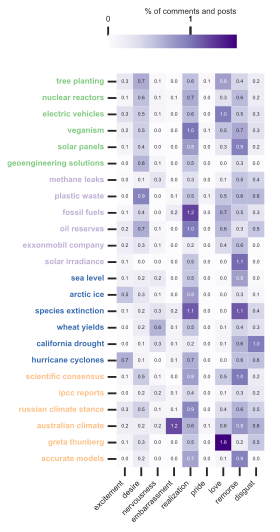

In [63]:
# Get all emotions present in the data
all_emotions = set()
for topic_emotions in emotion_data.values():
    all_emotions.update(topic_emotions.keys())

# Find emotions not in positive/negative/neutral lists
other_emotions = [e for e in all_emotions if e not in positive_emotions + negative_emotions + neutral_emotions]

if other_emotions:
    # Get top 6 topics by volume for each theme
    top_topics = []
    for theme in classified_topics:
        theme_topics = list(classified_topics[theme].keys())
        theme_topics.sort(key=lambda x: topic_volumes[x], reverse=True)
        top_topics.extend(theme_topics[:6])

    # Create data matrix for other emotions
    data_matrix_other = np.zeros((len(top_topics), len(other_emotions)))

    # Fill matrix with percentages 
    for i, topic in enumerate(top_topics):
        for j, emotion in enumerate(other_emotions):
            data_matrix_other[i,j] = emotion_data[topic].get(emotion, 0)

    # Create figure for other emotions
    plt.figure(figsize=(8, 8))
    ax = plt.gca()

    # Create heatmap
    sns.heatmap(data_matrix_other,
                xticklabels=other_emotions,
                yticklabels=[pretty_name[t] for t in top_topics],
                cmap='Purples',
                annot=True,
                fmt='.1f',
                cbar_kws={'label': '% of comments and posts',
                         'orientation': 'horizontal',
                         'location': 'top',
                         'shrink': 0.3,
                         'aspect': 20},
                square=True,
                annot_kws={"size": 5},
                ax=ax)

    # Color y-axis labels based on theme
    ytick_labels = ax.get_yticklabels()
    for i, topic in enumerate(top_topics):
        for theme, theme_topics in classified_topics.items():
            if topic in theme_topics:
                color = theme_to_color[theme]
                ytick_labels[i].set_color(color)
                ytick_labels[i].set_fontweight('bold')
                break

    # Customize appearance
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

    # Customize colorbar
    cbar = ax.collections[0].colorbar
    max_value = np.ceil(data_matrix_other.max())
    cbar.ax.set_xlim(0, max_value)
    cbar.ax.set_xticks([0, 1, 1])
    cbar.ax.set_box_aspect(0.08)
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label('% of comments and posts', size=8, labelpad=2)

    plt.tight_layout()

    # Save figures
    plt.savefig('figures/fig_emotions_heatmap_other.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.savefig('figures/fig_emotions_heatmap_other.png', format='png', bbox_inches='tight', dpi=300)
else:
    print("No other emotions found in the data")
